In [1]:
#!pip install --upgrade opencv-contrib-python  

In [2]:
#!pip install segmentation-models-pytorch 


In [3]:
#!pip install albumentations 

In [4]:
#!pip install matplotlib

In [5]:
#!pip install openpyxl

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from openpyxl import Workbook



In [7]:
height,width = (512,512)
torch.cuda.is_available()

True

In [8]:
X = sorted(glob.glob('data/Images/*'))
y = sorted(glob.glob('data/Masks/*'))

In [9]:
len(y)

116

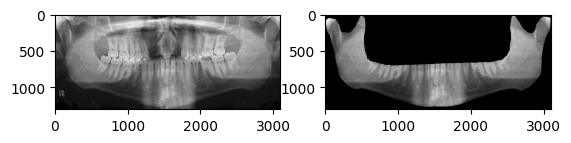

In [10]:
img = Image.open(X[0]).convert('L')
mask = Image.open(y[0]).convert('L')
plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(mask,cmap='gray')

In [11]:
X_ = X[0]
y_ = y[0]

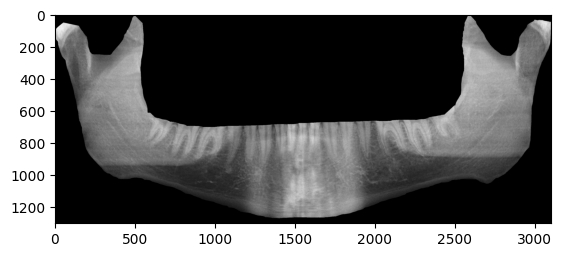

In [12]:
img = Image.open(X_)
mask = Image.open(y_).convert('L')
plt.subplot(1,1,1)
plt.imshow(mask,cmap='gray')

In [13]:
img, mask = np.array(img), np.array(mask)
transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
        ])
transformed = transform(image=img, mask=mask)
img = transformed['image']
mask = transformed['mask']


In [14]:
mask.shape,img.shape

((512, 512), (512, 512))

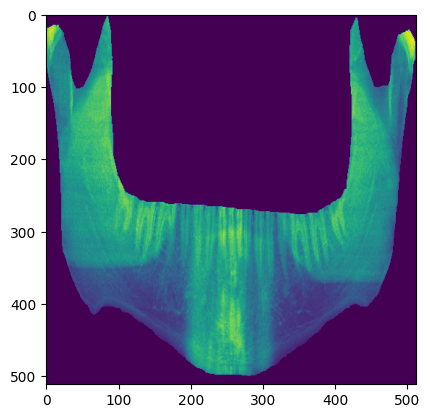

In [15]:
plt.imshow(mask)

In [16]:
img = np.expand_dims(img, axis=0)
img = img/255.0
img = torch.tensor(img)

In [17]:
img

tensor([[[0.8980, 0.9176, 0.8824,  ..., 0.7922, 0.7961, 0.8314],
         [0.8863, 0.9216, 0.8941,  ..., 0.7529, 0.7922, 0.8157],
         [0.8627, 0.8784, 0.8510,  ..., 0.7216, 0.7412, 0.8039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       dtype=torch.float64)

In [18]:

mask = mask/255.0
normalized_mask = (mask - mask.min()) / (mask.max() - mask.min())
# Set values greater than 0 to 1
normalized_mask[normalized_mask > 0] = 1
mask = normalized_mask

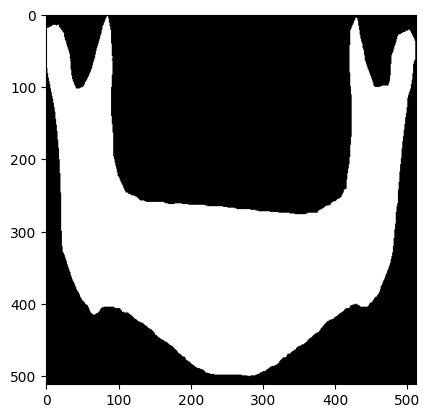

In [19]:

plt.imshow(mask,cmap='gray')
mask = np.expand_dims(mask, axis=0)
mask = torch.tensor(mask)

In [20]:
"""def normalization_mask (mask):
    normalized_mask = (mask - mask.min()) / (mask.max() - mask.min())
    # Set values greater than 0 to 1
    normalized_mask[normalized_mask > 0] = 1
    mask = normalized_mask"""


'def normalization_mask (mask):\n    normalized_mask = (mask - mask.min()) / (mask.max() - mask.min())\n    # Set values greater than 0 to 1\n    normalized_mask[normalized_mask > 0] = 1\n    mask = normalized_mask'

In [21]:
mask.shape

torch.Size([1, 512, 512])

In [22]:
img.shape, mask.shape

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [23]:
# Load Dataset

In [24]:
class Load_Data(Dataset):
    def __init__(self, image_list, mask_list):
        super().__init__()

        self.images_list = image_list
        self.mask_list = mask_list
        self.len = len(image_list)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
        ],is_check_shapes=False)
        
    def __getitem__(self, idx):
        img = Image.open(self.images_list[idx]).convert('L')
        mask = Image.open(self.mask_list[idx]).convert('L')
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.expand_dims(img, axis=0)
        img = img/255.0
        img = torch.tensor(img)

        mask = mask/255.0
        normalized_mask = (mask - mask.min()) / (mask.max() - mask.min())
        # Set values greater than 0 to 1
        normalized_mask[normalized_mask > 0] = 1
        mask = normalized_mask
        mask = np.expand_dims(mask, axis=0)
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [26]:
train_dataset = Load_Data(X_train, y_train)
valid_dataset = Load_Data(X_val, y_val)

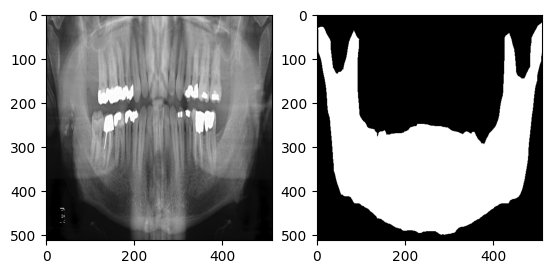

In [27]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap = 'gray')
axarr[0].imshow(np.squeeze(img.numpy()), cmap = 'gray')

In [28]:
# Model Evoluation

In [29]:
DEVICE='cuda'

EPOCHS=20
BATCH_SIZE=4
LR=0.005

ratio=0.5 #Various ratios could perform better for visualization
sample_num=2 

ENCODER='resnet50'
WEIGHTS='imagenet'

In [30]:
# Load Data

In [31]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
)

In [32]:
#Here we determine the encoder and weights from the above variables in Unet.

#The value of our loss function is the sum of the DiceLoss and BCEWithLogitsLoss.

In [33]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [34]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=1,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [35]:
model = SegmentationModel()
model.to(DEVICE);

In [36]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [37]:

def eval_fn(data_loader,model,arr=[]):
    
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            ##################################
            #IOU
            y_pred_thresholded_np = pred_mask.cpu().numpy()
            mask_iou_np = mask.cpu().numpy()

            # Calculate intersection and union
            intersection = np.logical_and(mask_iou_np, y_pred_thresholded_np)
            union = np.logical_or(mask_iou_np, y_pred_thresholded_np)

            # Convert back to PyTorch tensors
            intersection_tensor = torch.from_numpy(intersection)
            union_tensor = torch.from_numpy(union)

            # Calculate IoU score using PyTorch operations
            iou_score = torch.sum(intersection_tensor).float() / torch.sum(union_tensor).float()
            print("IoU score is: ", iou_score.item())
            arr.append(iou_score.item()) 

            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.squeeze(img.numpy()), cmap='gray')
            
            axarr[2].imshow(pred_mask.detach().cpu().squeeze(0).squeeze(0))
            print(pred_mask.shape)
            plt.show()
                    
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [38]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)

File Exists!
File Exists!


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


IoU score is:  0.6286943554878235
torch.Size([1, 1, 512, 512])


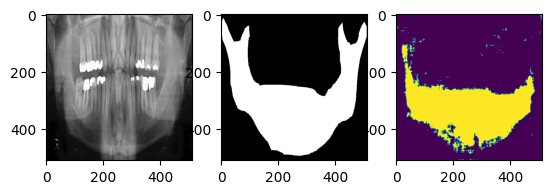

Epochs:1
Train_loss --> Dice: 0.4001270578457759 BCE: 0.49207799022014326 
Valid_loss --> Dice: 0.2879915237426758 BCE: 0.3368116120497386
Model Saved as model_0.28799dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


IoU score is:  0.887027382850647
torch.Size([1, 1, 512, 512])


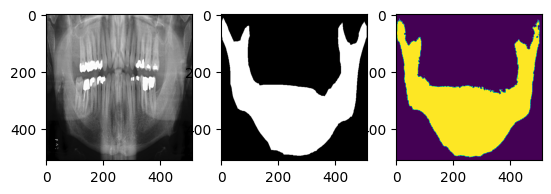

Epochs:2
Train_loss --> Dice: 0.1161220119549678 BCE: 0.16734861840422338 
Valid_loss --> Dice: 0.09558125336964925 BCE: 0.14427319169044495
Model Saved as model_0.09558dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


IoU score is:  0.8853705525398254
torch.Size([1, 1, 512, 512])


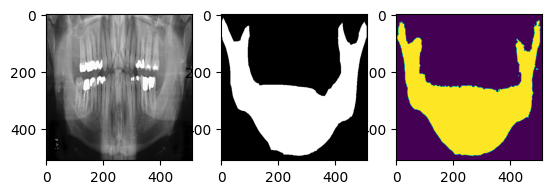

Epochs:3
Train_loss --> Dice: 0.07683633611752437 BCE: 0.11994099702972633 
Valid_loss --> Dice: 0.0821892221768697 BCE: 0.12701257318258286
Model Saved as model_0.08219dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


IoU score is:  0.9234892725944519
torch.Size([1, 1, 512, 512])


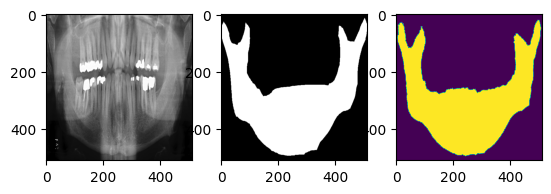

Epochs:4
Train_loss --> Dice: 0.06385974242137028 BCE: 0.09884429780336526 
Valid_loss --> Dice: 0.07347226142883301 BCE: 0.11730362474918365
Model Saved as model_0.07347dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


IoU score is:  0.9307664036750793
torch.Size([1, 1, 512, 512])


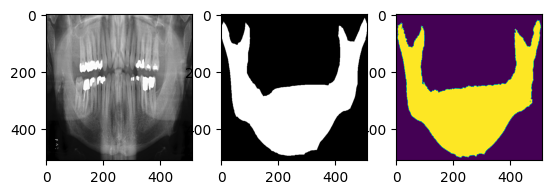

Epochs:5
Train_loss --> Dice: 0.05548536548247704 BCE: 0.08902755379676819 
Valid_loss --> Dice: 0.059392074743906655 BCE: 0.09104406585295995
Model Saved as model_0.05939dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


IoU score is:  0.9322149157524109
torch.Size([1, 1, 512, 512])


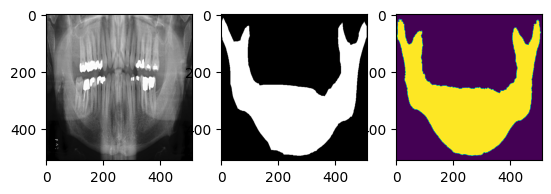

Epochs:6
Train_loss --> Dice: 0.04902777992762052 BCE: 0.07611623549690613 
Valid_loss --> Dice: 0.05830244223276774 BCE: 0.09518632541100185
Model Saved as model_0.05830dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


IoU score is:  0.9294377565383911
torch.Size([1, 1, 512, 512])


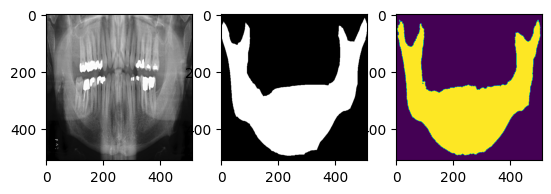

Epochs:7
Train_loss --> Dice: 0.04522046676048866 BCE: 0.07159147884410161 
Valid_loss --> Dice: 0.05545792977015177 BCE: 0.0902278870344162
Model Saved as model_0.05546dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


IoU score is:  0.9355310201644897
torch.Size([1, 1, 512, 512])


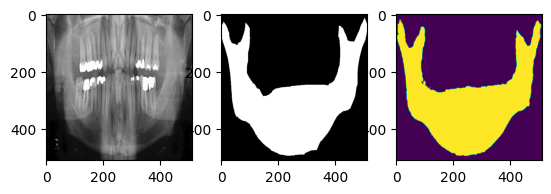

Epochs:8
Train_loss --> Dice: 0.04059155399982746 BCE: 0.06312598603276107 
Valid_loss --> Dice: 0.05349055926005045 BCE: 0.08922271182139714
Model Saved as model_0.05349dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


IoU score is:  0.9280929565429688
torch.Size([1, 1, 512, 512])


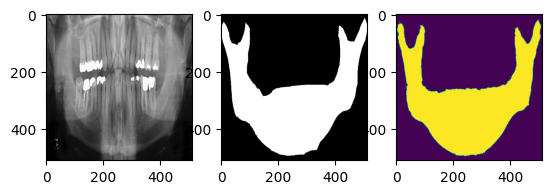

Epochs:9
Train_loss --> Dice: 0.03805824885001549 BCE: 0.060122620027798876 
Valid_loss --> Dice: 0.05283663670221964 BCE: 0.09396062046289444
Model Saved as model_0.05284dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


IoU score is:  0.9351595640182495
torch.Size([1, 1, 512, 512])


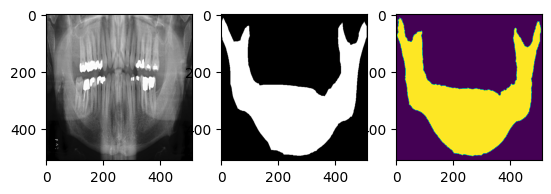

Epochs:10
Train_loss --> Dice: 0.03654560446739197 BCE: 0.05756253505555483 
Valid_loss --> Dice: 0.050937275091807045 BCE: 0.08893383791049321
Model Saved as model_0.05094dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


IoU score is:  0.9254158139228821
torch.Size([1, 1, 512, 512])


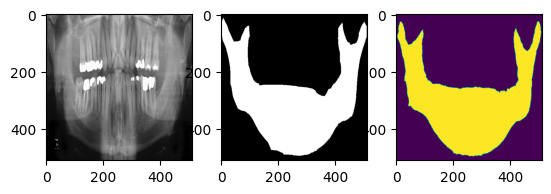

Epochs:11
Train_loss --> Dice: 0.03379268829639141 BCE: 0.052355311381129116 
Valid_loss --> Dice: 0.04926484823226929 BCE: 0.09054416418075562
Model Saved as model_0.04926dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


IoU score is:  0.9237288236618042
torch.Size([1, 1, 512, 512])


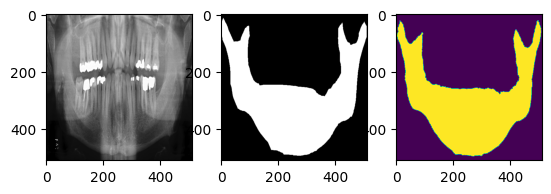

Epochs:12
Train_loss --> Dice: 0.032368630170822144 BCE: 0.05121874064207077 
Valid_loss --> Dice: 0.04398838678995768 BCE: 0.08288697650035222
Model Saved as model_0.04399dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


IoU score is:  0.9390509724617004
torch.Size([1, 1, 512, 512])


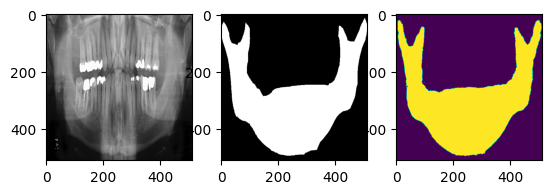

Epochs:13
Train_loss --> Dice: 0.030451187720665567 BCE: 0.04693083737332087 
Valid_loss --> Dice: 0.04487323760986328 BCE: 0.0857523853580157


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


IoU score is:  0.9246507287025452
torch.Size([1, 1, 512, 512])


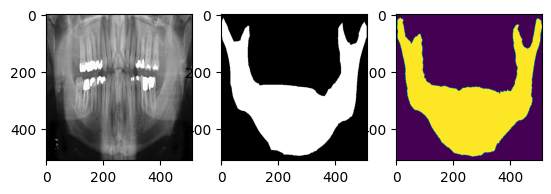

Epochs:14
Train_loss --> Dice: 0.028661170831093423 BCE: 0.04531120895766295 
Valid_loss --> Dice: 0.043958584467569985 BCE: 0.08833306282758713
Model Saved as model_0.04396dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


IoU score is:  0.9155304431915283
torch.Size([1, 1, 512, 512])


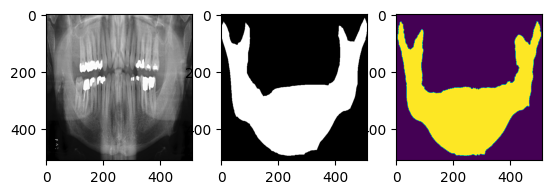

Epochs:15
Train_loss --> Dice: 0.02982186354123629 BCE: 0.04781879785542305 
Valid_loss --> Dice: 0.04369105895360311 BCE: 0.08606415490309398
Model Saved as model_0.04369dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


IoU score is:  0.9316180348396301
torch.Size([1, 1, 512, 512])


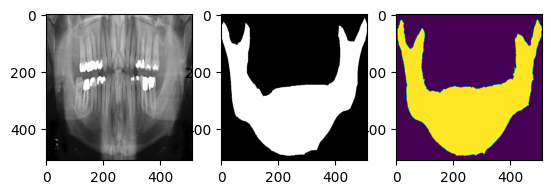

Epochs:16
Train_loss --> Dice: 0.028277763953575723 BCE: 0.04469359021347303 
Valid_loss --> Dice: 0.0429453452428182 BCE: 0.08496043582757314
Model Saved as model_0.04295dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


IoU score is:  0.9356922507286072
torch.Size([1, 1, 512, 512])


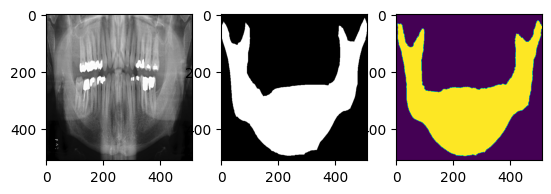

Epochs:17
Train_loss --> Dice: 0.027675397120989285 BCE: 0.042913879840992965 
Valid_loss --> Dice: 0.04203303654988607 BCE: 0.08205270022153854
Model Saved as model_0.04203dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


IoU score is:  0.9385355710983276
torch.Size([1, 1, 512, 512])


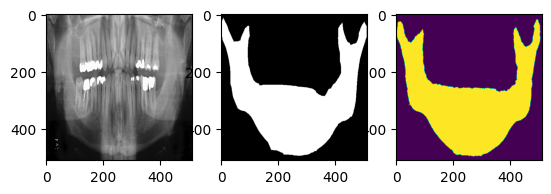

Epochs:18
Train_loss --> Dice: 0.02662851489507235 BCE: 0.04154864712976492 
Valid_loss --> Dice: 0.04240997632344564 BCE: 0.08544305215279262


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


IoU score is:  0.939788818359375
torch.Size([1, 1, 512, 512])


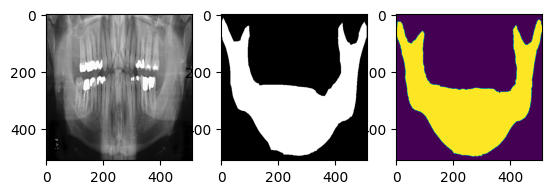

Epochs:19
Train_loss --> Dice: 0.024789016980391283 BCE: 0.0392813657482083 
Valid_loss --> Dice: 0.04023667176564535 BCE: 0.0826362743973732
Model Saved as model_0.04024dice.pt


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


IoU score is:  0.9198405146598816
torch.Size([1, 1, 512, 512])


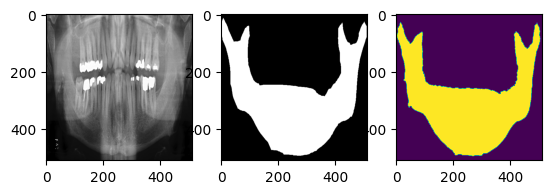

Epochs:20
Train_loss --> Dice: 0.02469433270967924 BCE: 0.03911933976297195 
Valid_loss --> Dice: 0.04341121514638265 BCE: 0.09478928397099178


In [39]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf
iou_score_array = []
wb = Workbook()
sheet = wb.active

try:
    os.mkdir("models")
except:
    print("File Exists!")

try:
    os.mkdir("models/" + ENCODER)
except:
    print("File Exists!")

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model,iou_score_array)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    #To publish data in an Excel file.
    cell_header_3 =sheet.cell(row=1,column=1)
    cell_header_3.value = "EPOCH"

    cell_header_1 =sheet.cell(row=1,column=3)
    cell_header_1.value = "DICE" 

    cell_header_2 =sheet.cell(row=1,column=2)
    cell_header_2.value = "BCE" 

     
     
    cell_dice = sheet.cell(row=i+2, column=3)  # Column 1, increasing row
    cell_dice.value = valid_dice
    cell_bce = sheet.cell(row=i+2, column=2)  # Column 1, increasing row
    cell_bce.value = valid_bce
    cell_epoch = sheet.cell(row=i+2, column=1)  # Column 1, increasing row
    cell_epoch.value = i+1
    wb.save("scores.xlsx")
    
    if valid_dice < best_val_dice_loss: #or valid_bce < best_val_bce_loss
        torch.save(model.state_dict(),"models/{}/model_{:.5f}dice.pt".format(ENCODER, valid_dice))
        print('Model Saved as model_{:.5f}dice.pt'.format(valid_dice))
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

In [40]:
#These code lines are for saving the iou scores in an excel file 
from openpyxl import load_workbook
wb = load_workbook("scores.xlsx")
sheet = wb.active
i = 1
cell_header_4 = sheet.cell(row = 1,column=4)
cell_header_4.value = "IoU"
for item in iou_score_array:
    i=i+1
    
    cell_iou = sheet.cell(row=i, column=4)
    cell_iou.value = item
    wb.save("scores.xlsx")

IoU score is:  0.9374658465385437


Text(0.5, 1.0, 'Predicted Mask')

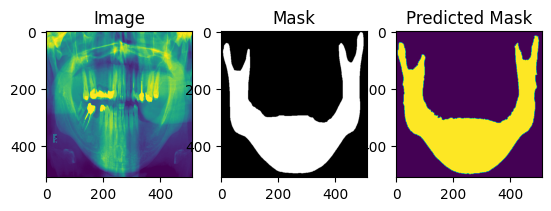

In [41]:
num=0
ratio=0.5
PATH = f"models/{ENCODER}/model_0.04244dice.pt"
model.load_state_dict(torch.load(PATH))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0
##################################
#IOU
y_pred_thresholded_np = pred_mask.cpu().numpy()
mask_iou_np = mask.cpu().numpy()

# Calculate intersection and union
intersection = np.logical_and(mask_iou_np, y_pred_thresholded_np)
union = np.logical_or(mask_iou_np, y_pred_thresholded_np)

# Convert back to PyTorch tensors
intersection_tensor = torch.from_numpy(intersection)
union_tensor = torch.from_numpy(union)

# Calculate IoU score using PyTorch operations
iou_score = torch.sum(intersection_tensor).float() / torch.sum(union_tensor).float()
print("IoU score is: ", iou_score.item())

f, axarr = plt.subplots(1,3) 
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[0].set_title('Image')
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[1].set_title('Mask')
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
axarr[2].set_title('Predicted Mask')



In [ ]:
import os
import subprocess

def main():
    # GitHub kullanıcı adı ve repo adı
    github_username = "DenizYald3iz"
    repo_name = "Segmentation_Model"

    # Python dosyasının bulunduğu dizin ve dosya adı
    dosya_dizini = ""
    dosya_adi = "segment_kaggle.ipynb"

    # GitHub repo URL'si
    repo_url = f"https://github.com/{github_username}/{repo_name}.git"

    # Git deposu oluşturma
    os.chdir(dosya_dizini)
    subprocess.run(["git", "init"])

    # Dosyaları ve değişiklikleri ekleme
    subprocess.run(["git", "add", dosya_adi])
    subprocess.run(["git", "commit", "-m", "İlk commit"])

    # GitHub repo'sunu ekleyip yükleme
    subprocess.run(["git", "remote", "add", "origin", repo_url])
    subprocess.run(["git", "push", "-u", "origin", "master"])

if __name__ == "__main__":
    main()


'c:\\Users\\deniz\\Desktop\\Panoramic Dental X-rays With Segmented Mandibles'